In [1]:
import pandas as pd
import numpy as np

stocks = pd.read_csv("data/stocks_ti.csv")

import warnings

warnings.filterwarnings("ignore")

In [2]:
from utils import add_sentiment_ti

# add ti to sentiment features
stocks = add_sentiment_ti(stocks)

### Classifiers

I'm going to run Logistic Regression, Random Forest, and XGBoost classifiers on the data. Each model will be evaluated on the following datasets:
1. Previous days SPY returns
2. Previous subset plus previous days sector ETFs returns
3. Previous subset plus sentiment scores
4. Data from 2. plus technical indicators
5. Full dataset comprising sector ETFs, sentiment scores, and technical indicators

The previous process will be iterated trying to predict 1 day, 5 day, 13 day and 21 day returns.

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


def plot_all_confusion_matrices(feature_types_dict, title):
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))
    fig.suptitle(title, fontsize=16)

    for i, (feature_type, days_dict) in enumerate(feature_types_dict.items()):
        nons = 0
        for j, (days, results) in enumerate(days_dict.items()):
            if results is None:
                nons += 1
            if results is not None:
                cm = results[1]
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot(
                    ax=axes[i, j - nons],
                    cmap="Blues",
                    values_format=".0f",
                    colorbar=False,
                )
                axes[i, j - nons].set_title(
                    f"Feature type: {feature_type} \n Predicting {days} day(s) return",
                    fontsize=10,
                )

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave some space at the top for the title
    plt.show()

### Input data sequentially

In [8]:
from utils import prep_classifier_data, feature_type_map

fm = feature_type_map(stocks)
columns1 = list(set(fm["spy_returns"]))
columns2 = list(set(fm["returns"]))
columns3 = list(set(fm["returns"] + fm["sentiment"]))
columns4 = list(set(fm["returns"] + fm["technical"]))
columns5 = stocks.columns

# 5 random states on which to run the models
import random

random_states = random.sample(range(int(1e9)), 5)

# dictionary to store tuple of (pred, confusion_matrix, classifier) for each day, for each feature type, for each model
models_key = {
    "logistic_regression": {
        "spy_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 8: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 8: None, 13: None, 21: None},
    },
    "random_forest": {
        "spy_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 8: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 8: None, 13: None, 21: None},
    },
    "xgboost": {
        "spy_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 8: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 8: None, 13: None, 21: None},
    },
    "mlp": {
        "spy_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_sentiment": {1: None, 5: None, 8: None, 13: None, 21: None},
        "sector_returns_technical": {1: None, 5: None, 8: None, 13: None, 21: None},
        "all_features": {1: None, 5: None, 8: None, 13: None, 21: None},
    },
}

y_tests = {
    "spy_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
    "sector_returns": {1: None, 5: None, 8: None, 13: None, 21: None},
    "sector_returns_sentiment": {1: None, 5: None, 8: None, 13: None, 21: None},
    "sector_returns_technical": {1: None, 5: None, 8: None, 13: None, 21: None},
    "all_features": {1: None, 5: None, 8: None, 13: None, 21: None},
}

# loop 5 times to get average results
keys_list = []

for k, rs in enumerate(random_states):
    # loop through each day and each feature type
    for i, day_no in enumerate([1, 8, 21]):
        for j, features in enumerate(
            [columns1, columns2, columns3, columns4, columns5]
        ):
            features_type = [
                "spy_returns",
                "sector_returns",
                "sector_returns_sentiment",
                "sector_returns_technical",
                "all_features",
            ][j]

            # prep data
            X_train, X_test, y_train, y_test = prep_classifier_data(
                stocks[features].copy(), day_no, sequential=True
            )

            if y_tests[features_type][day_no] is None:
                y_tests[features_type][day_no] = y_test

            ## models
            from utils import (
                logistic_regression,
                random_forest_classifier,
                xgboost_classifier,
                mlp_classifier,
            )

            # logistic regression
            print(f"Logistic Regression on {day_no} day(s) with {features_type}...")
            models_key["logistic_regression"][features_type][
                day_no
            ] = logistic_regression(X_train, X_test, y_train, y_test, random_state=rs)

            # random forest
            print(f"Random Forest on {day_no} day(s) with {features_type}...")
            models_key["random_forest"][features_type][
                day_no
            ] = random_forest_classifier(
                X_train, X_test, y_train, y_test, random_state=rs
            )

            # xgboost
            print(f"XGBoost on {day_no} day(s) with {features_type}...")
            models_key["xgboost"][features_type][day_no] = xgboost_classifier(
                X_train, X_test, y_train, y_test, random_state=rs
            )

            # mlp
            print(f"MLP on {day_no} day(s) with {features_type}...")
            models_key["mlp"][features_type][day_no] = mlp_classifier(
                X_train, X_test, y_train, y_test, random_state=rs
            )
    keys_list.append((rs, models_key, y_tests))

Logistic Regression on 1 day(s) with spy_returns...
Accuracy: 0.59
Random Forest on 1 day(s) with spy_returns...
Accuracy: 0.52
XGBoost on 1 day(s) with spy_returns...
Accuracy: 0.48
MLP on 1 day(s) with spy_returns...
Accuracy: 0.54
Logistic Regression on 1 day(s) with sector_returns...
Accuracy: 0.58
Random Forest on 1 day(s) with sector_returns...
Accuracy: 0.46
XGBoost on 1 day(s) with sector_returns...
Accuracy: 0.55
MLP on 1 day(s) with sector_returns...
Accuracy: 0.49
Logistic Regression on 1 day(s) with sector_returns_sentiment...
Accuracy: 0.59
Random Forest on 1 day(s) with sector_returns_sentiment...
Accuracy: 0.50
XGBoost on 1 day(s) with sector_returns_sentiment...
Accuracy: 0.52
MLP on 1 day(s) with sector_returns_sentiment...
Accuracy: 0.57
Logistic Regression on 1 day(s) with sector_returns_technical...
Accuracy: 0.47
Random Forest on 1 day(s) with sector_returns_technical...
Accuracy: 0.45
XGBoost on 1 day(s) with sector_returns_technical...
Accuracy: 0.47
MLP on 1 day

MLP seems to be performing best all around.

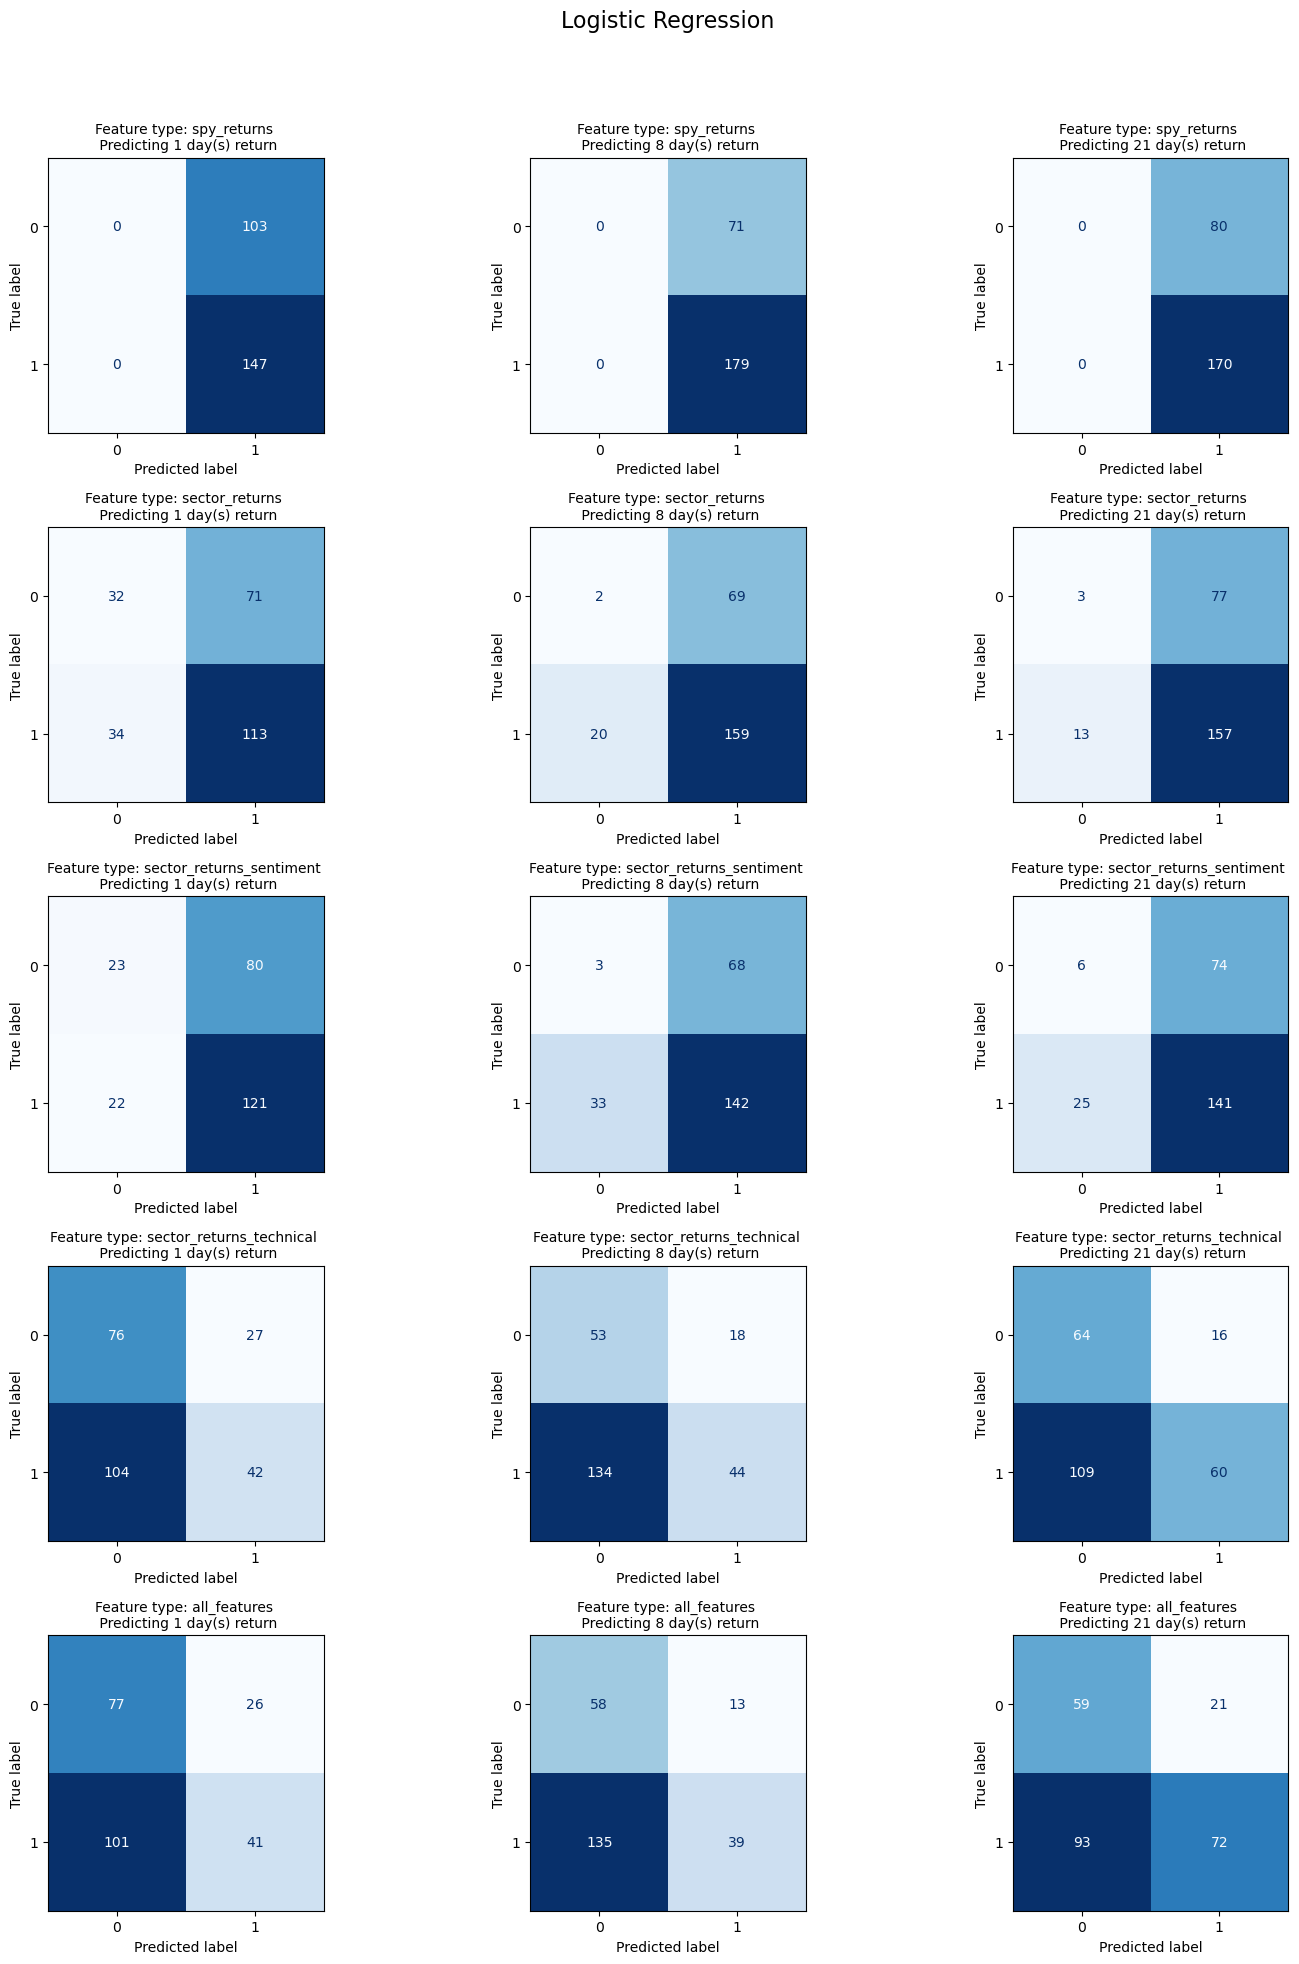

In [23]:
plot_all_confusion_matrices(models_key["logistic_regression"], "Logistic Regression")

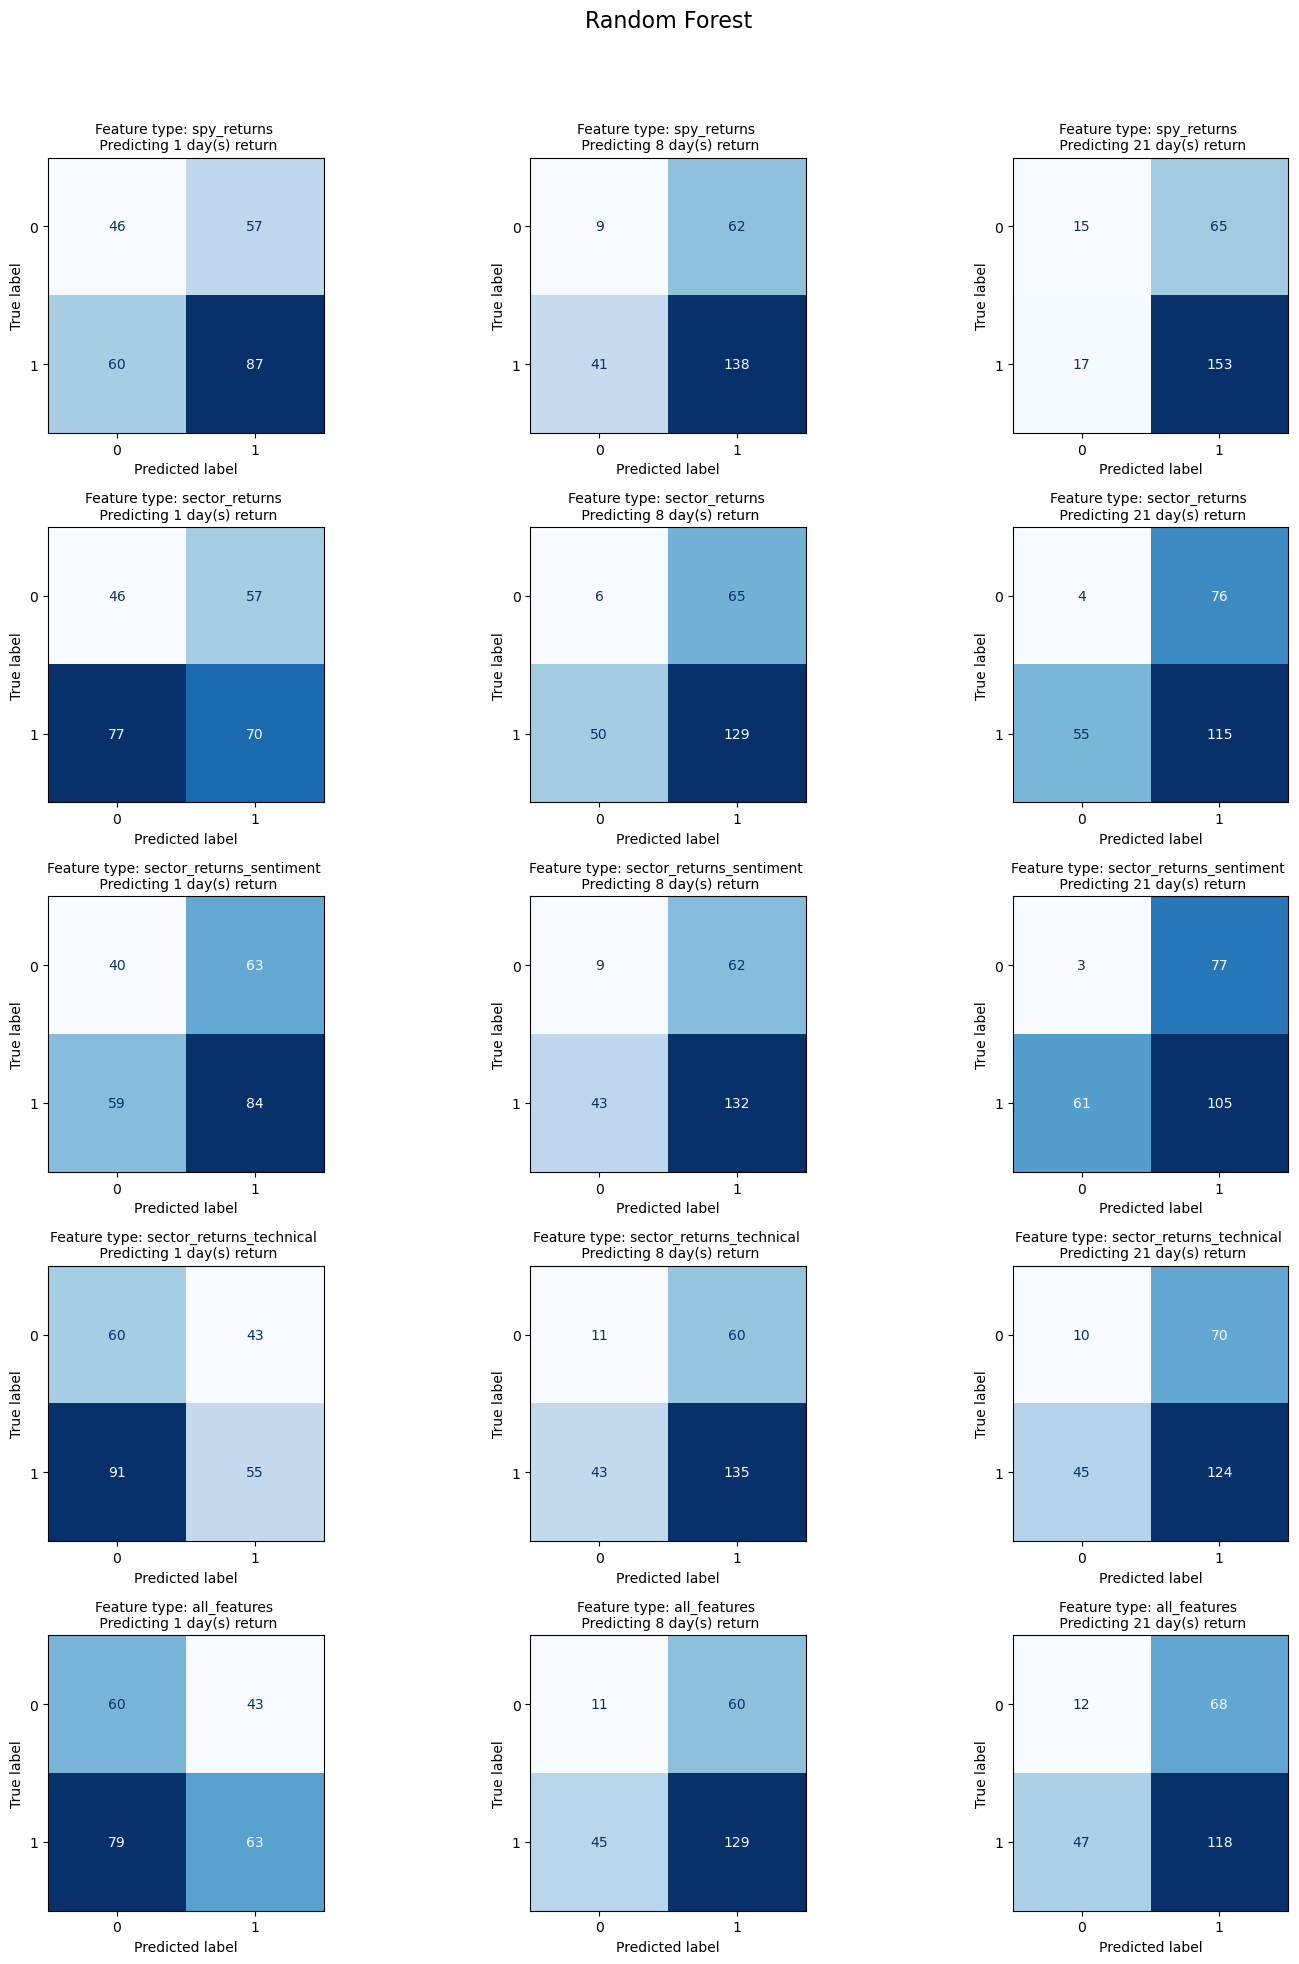

In [24]:
plot_all_confusion_matrices(models_key["random_forest"], "Random Forest")

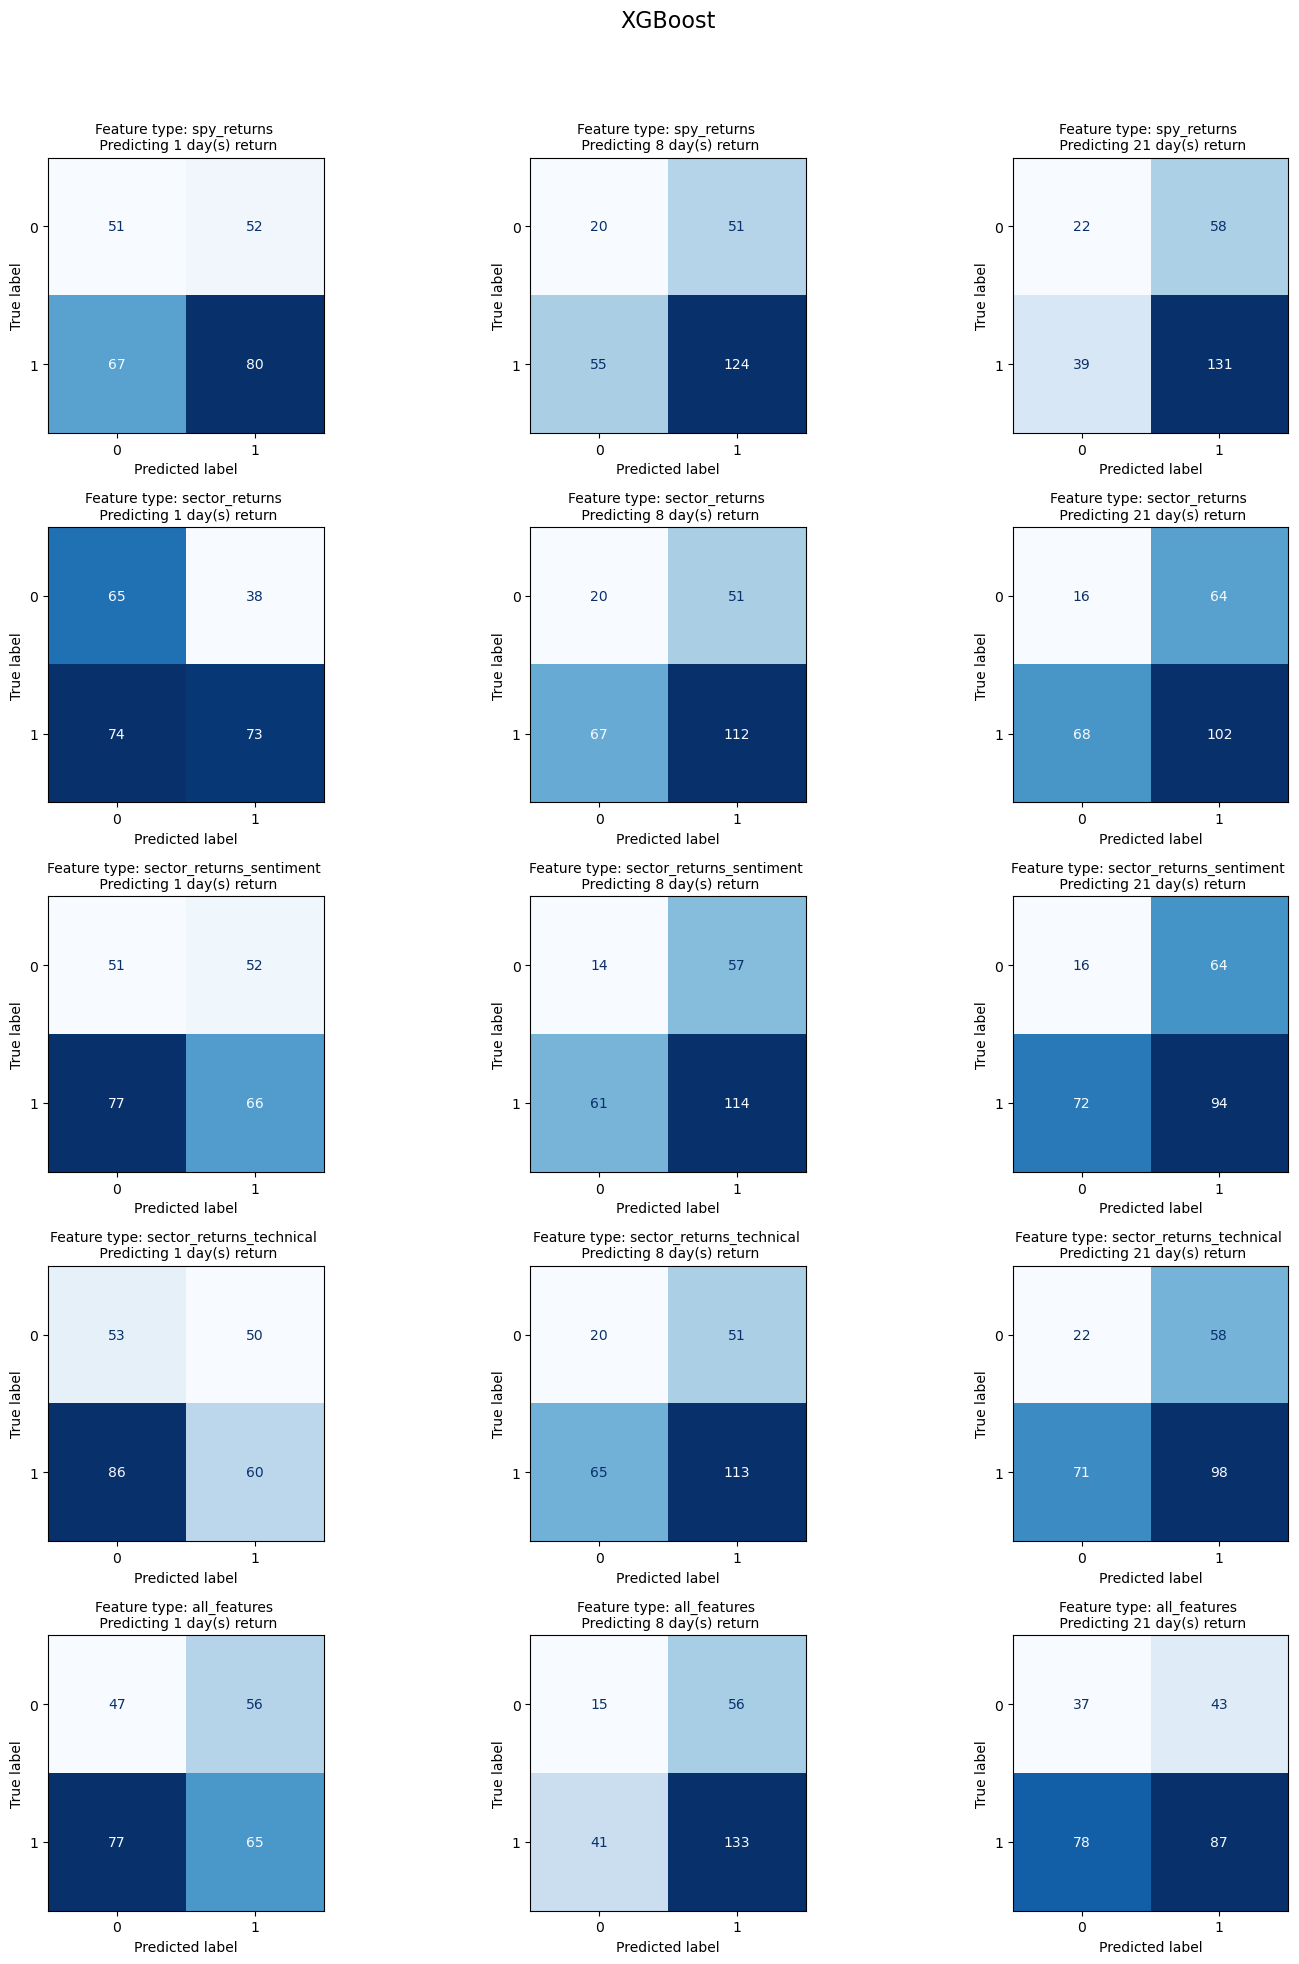

In [25]:
plot_all_confusion_matrices(models_key["xgboost"], "XGBoost")

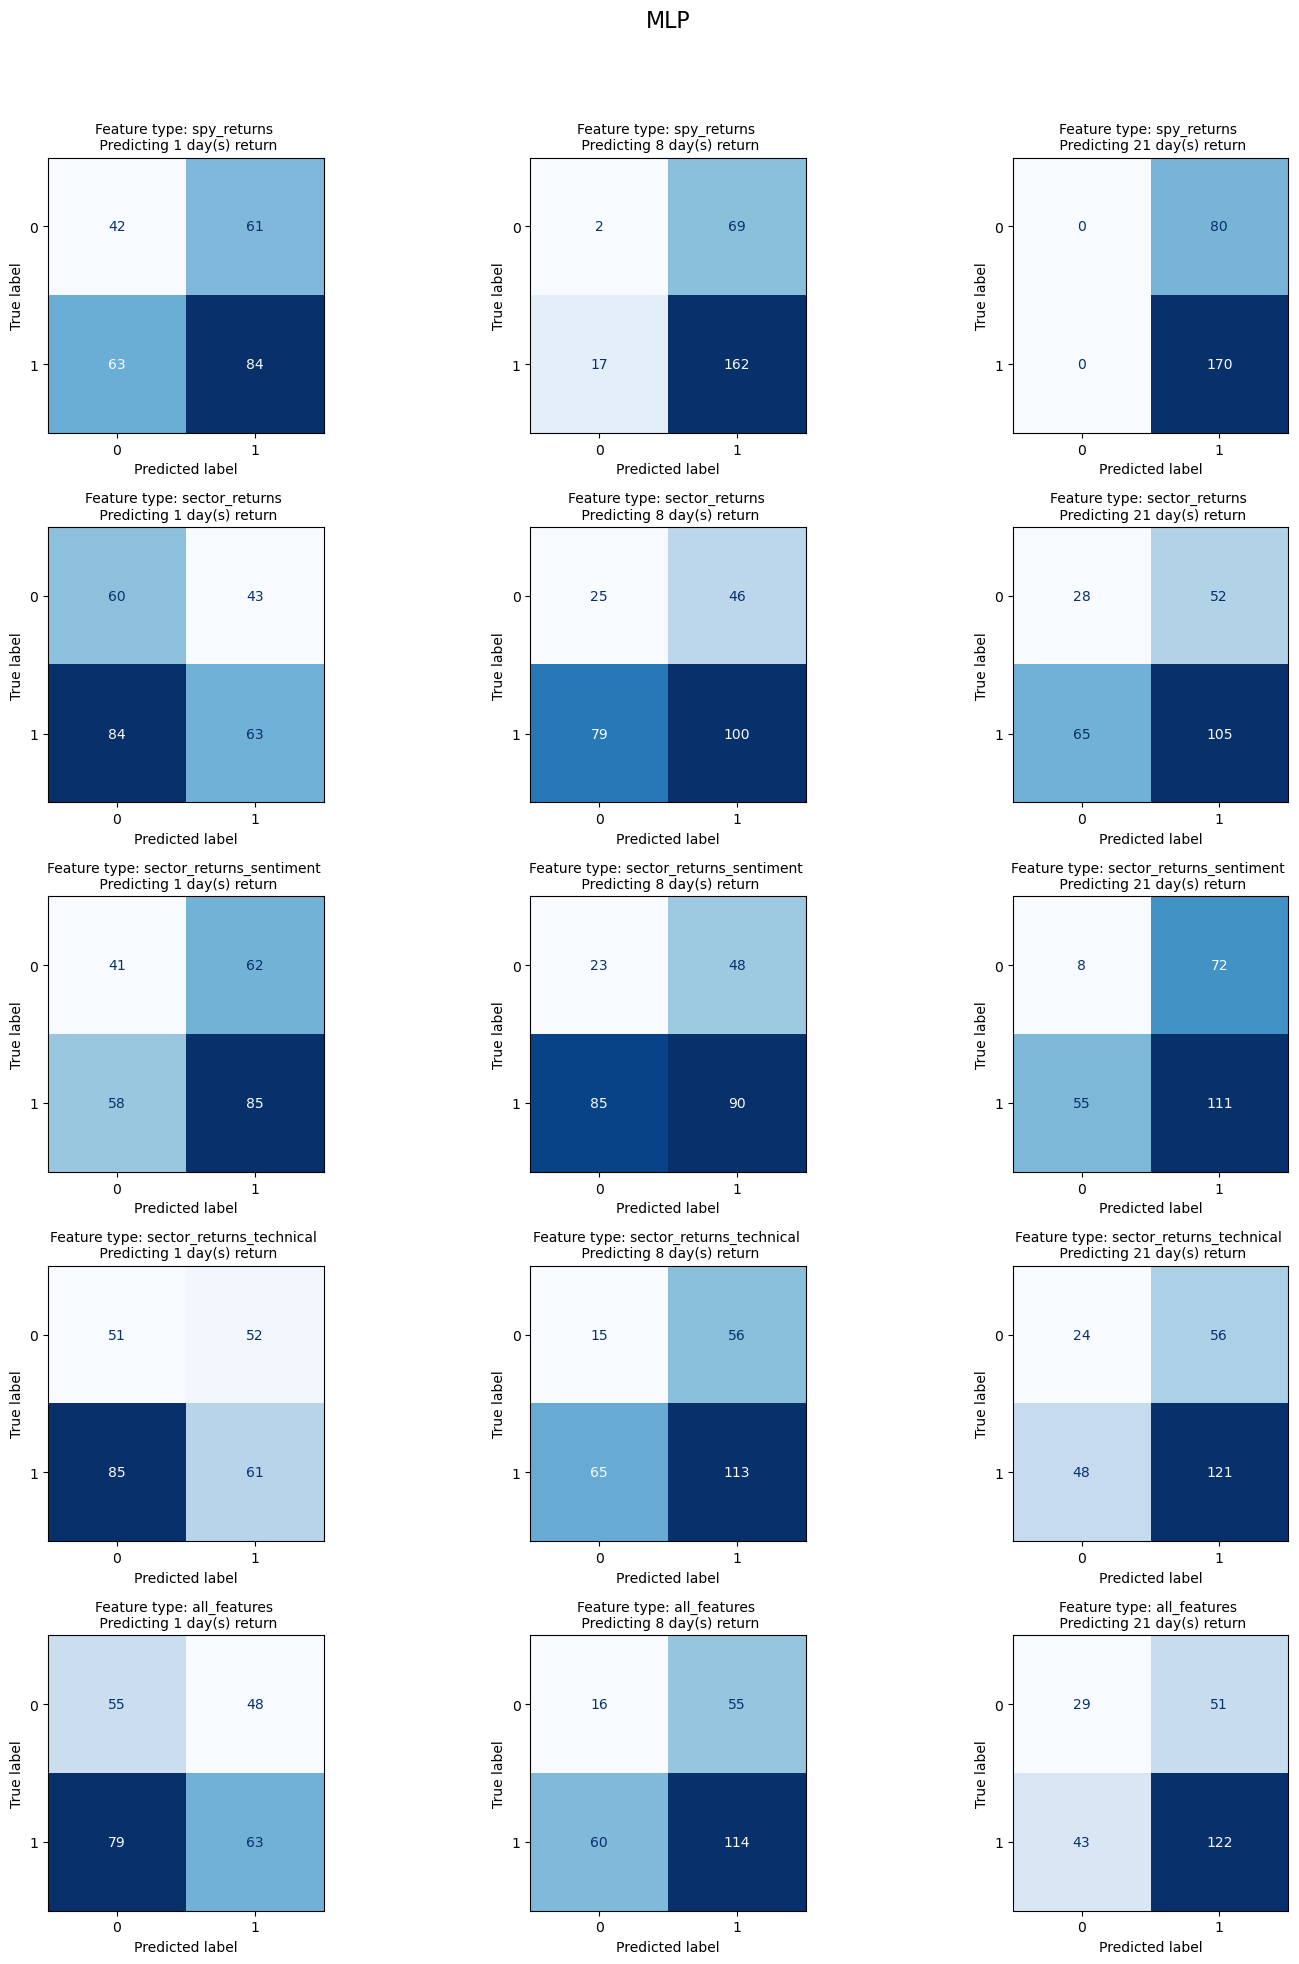

In [26]:
plot_all_confusion_matrices(models_key["mlp"], "MLP")

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from utils import prep_classifier_data, feature_type_map, mlp_classifier

mlp_results2 = {
    "sector_returns": {1: [], 8: [], 13: [], 21: []},
    "sector_returns_sentiment": {1: [], 8: [], 13: [], 21: []},
    "sector_returns_technical": {1: [], 8: [], 13: [], 21: []},
    "all_features": {1: [], 8: [], 13: [], 21: []},
}


# plot ROC curve for MLP

fm = feature_type_map(stocks)
columns2 = list(set(fm["returns"]))
columns3 = list(set(fm["returns"] + fm["sentiment"]))
columns4 = list(set(fm["returns"] + fm["technical"]))
columns5 = stocks.columns

fig, axes = plt.subplots(nrows=5, figsize=(10, 30))

import random

random_states = random.sample(range(int(1e9)), 5)

for rs in random_states:
    for i, day_no in enumerate([1, 8, 13, 21]):
        for j, features in enumerate([columns2, columns3, columns4, columns5]):
            features_type = [
                "sector_returns",
                "sector_returns_sentiment",
                "sector_returns_technical",
                "all_features",
            ][j]

            X_train, X_test, y_train, y_test = prep_classifier_data(
                stocks[features].copy(), day_no, sequential=True
            )

            # mlp
            print(f"MLP on {day_no} day(s) with {features_type}...")
            y_pred, _, _ = mlp_classifier(
                X_train, X_test, y_train, y_test, random_state=rs
            )

            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            mlp_results2[features_type][day_no].append((y_pred, y_test))

#         # Plot ROC curve on the subplot for this day_no
#         axes[i].plot(fpr, tpr, label=f"{features_type} (area = {roc_auc:.2f})")

#     # Chance line
#     axes[i].plot([0, 1], [0, 1], color='navy', linestyle='--')
#     # Set labels and title for this subplot
#     axes[i].set_xlabel("False Positive Rate")
#     axes[i].set_ylabel("True Positive Rate")
#     axes[i].set_title(f"ROC Curve for {day_no} day(s)")
#     axes[i].legend()

# # Show the plot
# plt.tight_layout()
# plt.show()


In [26]:
import pickle

# store mlp_results2: dict with tuple of (preds, y_tests) for each day, for each feature type on 5 different random states
with open("data/mlp_results2.pkl", "wb") as f:
    pickle.dump(mlp_results2, f)


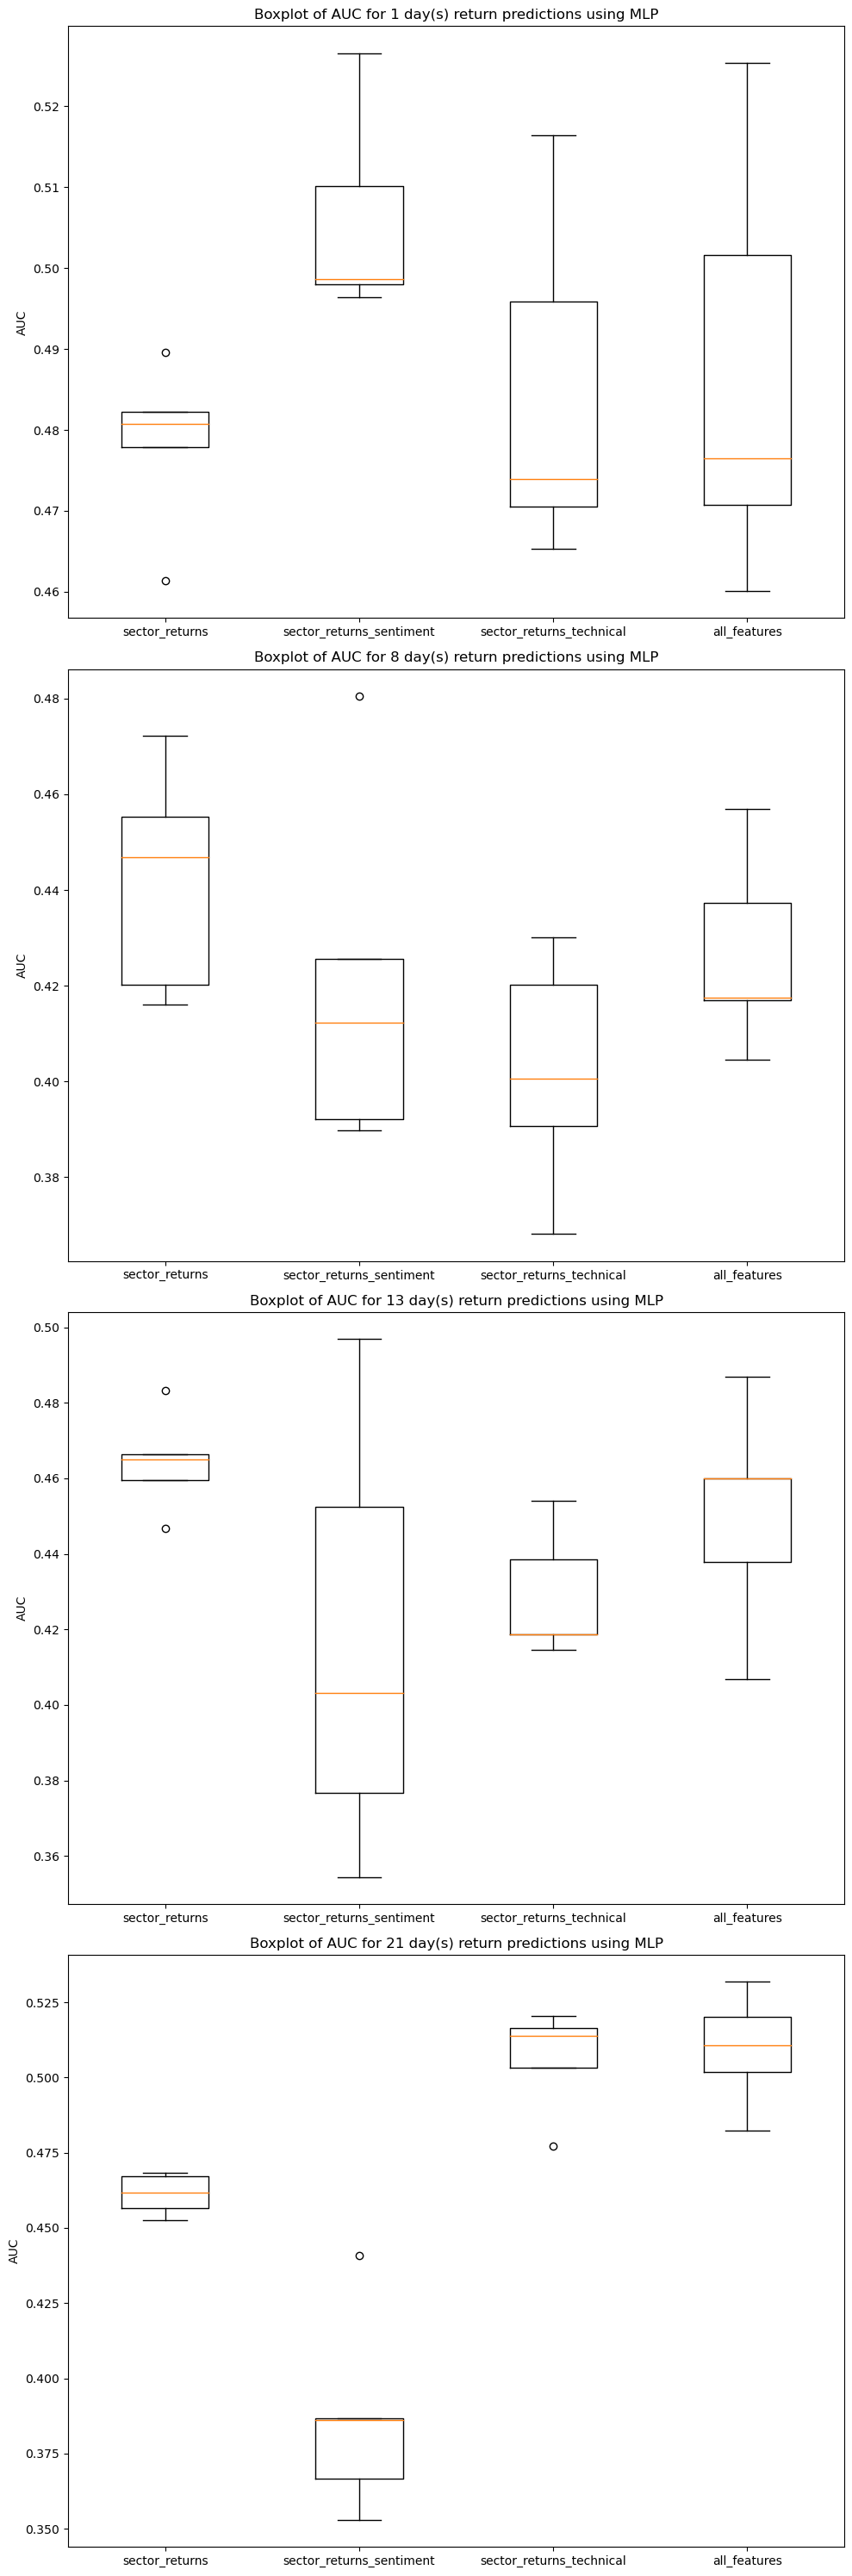

In [29]:
fig, axes = plt.subplots(nrows=4, figsize=(10, 30))

# For each day_no
for i, day_no in enumerate([1, 8, 13, 21]):
    # For each features_type
    for j, features_type in enumerate(
        [
            "sector_returns",
            "sector_returns_sentiment",
            "sector_returns_technical",
            "all_features",
        ]
    ):
        # Calculate AUC for each prediction
        aucs = [
            auc(*roc_curve(y_test, y_pred)[:2])
            for y_pred, y_test in mlp_results2[features_type][day_no]
        ]

        # Add AUCs to boxplot data
        if j == 0:
            boxplot_data = [aucs]
        else:
            boxplot_data.append(aucs)

    # Create boxplot on the subplot for this day_no
    axes[i].boxplot(
        boxplot_data,
        labels=[
            "sector_returns",
            "sector_returns_sentiment",
            "sector_returns_technical",
            "all_features",
        ],
    )
    axes[i].set_title(
        f"Boxplot of AUC for {day_no} day(s) return predictions using MLP"
    )
    axes[i].set_ylabel("AUC")

# Show the plot
plt.tight_layout()
plt.show()

# Save figure
fig.savefig("data/mlp_boxplots.png")


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from utils import prep_classifier_data, feature_type_map, mlp_classifier

mlp_results = {
    "sector_returns": {1: [], 8: [], 13: [], 21: []},
    "sector_returns_sentiment": {1: [], 8: [], 13: [], 21: []},
    "sector_returns_technical": {1: [], 8: [], 13: [], 21: []},
    "all_features": {1: [], 8: [], 13: [], 21: []},
}


# plot ROC curve for MLP

fm = feature_type_map(stocks)
columns2 = list(set(fm["returns"]))
columns3 = list(set(fm["returns"] + fm["sentiment"]))
columns4 = list(set(fm["returns"] + fm["technical"]))
columns5 = stocks.columns


fig, axes = plt.subplots(nrows=5, figsize=(10, 30))

for i, day_no in enumerate([1, 5, 8, 13, 21]):
    for j, features in enumerate([columns1, columns2, columns3, columns4, columns5]):
        features_type = [
            "spy_returns",
            "sector_returns",
            "sector_returns_sentiment",
            "sector_returns_technical",
            "all_features",
        ][j]

        X_train, X_test, y_train, y_test = prep_classifier_data(
            stocks[features].copy(), day_no, sequential=True
        )

        # mlp
        print(f"MLP on {day_no} day(s) with {features_type}...")
        y_pred, _, _ = mlp_classifier(
            X_train, X_test, y_train, y_test, random_state=257
        )

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        mlp_results[features_type][day_no] = (y_pred, y_test)

        # Plot ROC curve on the subplot for this day_no
        axes[i].plot(fpr, tpr, label=f"{features_type} (area = {roc_auc:.2f})")

        # Add dashed chance line
        axes[i].plot([0, 1], [0, 1], color="navy", linestyle="--")

    # Chance line
    axes[i].plot([0, 1], [0, 1], color="navy", linestyle="--")
    # Set labels and title for this subplot
    axes[i].set_xlabel("False Positive Rate")
    axes[i].set_ylabel("True Positive Rate")
    axes[i].set_title(f"ROC Curve for {day_no} day(s)")
    axes[i].legend()

# Show the plot
plt.tight_layout()
plt.show()


Accuracy: 0.57
Accuracy: 0.56
Accuracy: 0.56
Accuracy: 0.58
Accuracy: 0.55
Accuracy: 0.57


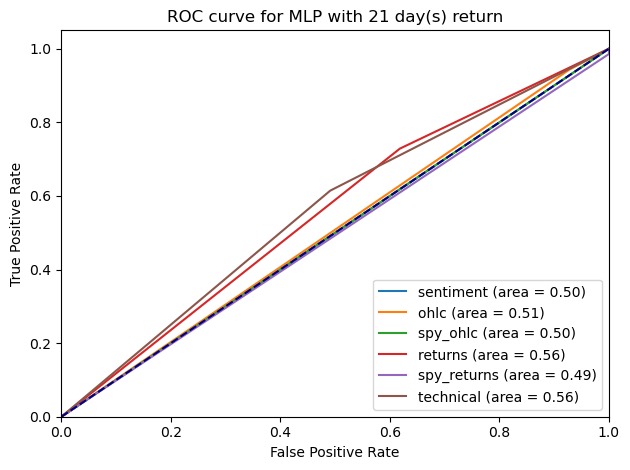

In [11]:
# plot ROC curves for all feature types in a single plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from utils import prep_classifier_data, feature_type_map, mlp_classifier

fm = feature_type_map(stocks)
columns1 = list(set(fm["spy_returns"]))
columns2 = list(set(fm["returns"]))
columns3 = list(set(fm["returns"] + fm["sentiment"]))
columns4 = list(set(fm["returns"] + fm["technical"]))
columns5 = stocks.columns

for feature_type, cols in fm.items():
    X_train, X_test, y_train, y_test = prep_classifier_data(
        stocks[cols].copy(), 21, sequential=True, test_size=0.1
    )

    y_pred, cm, clf = mlp_classifier(X_train, X_test, y_train, y_test, random_state=257)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{feature_type} (area = {roc_auc:.2f})")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve for MLP with 21 day(s) return")
    plt.legend(loc="lower right")

# Chance line
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
## feature importance
# random forest
from utils import (
    plot_feature_importance,
    prep_classifier_data,
    random_forest_classifier,
)

X_train, X_test, y_train, y_test = prep_classifier_data(
    stocks.copy(),
    21,
    sequential=False,
)

rf = random_forest_classifier(X_train, X_test, y_train, y_test)[2]

plot_feature_importance(rf, X_train, 21)

In [15]:
feature_importance = rf.feature_importances_
feature_names = np.arange(X_train.shape[1])
sorted_idx = feature_importance.argsort()[::-1]
stocks.columns[sorted_idx]

Index(['XLV_OPEN', 'XLU_ewm_log_ret_1d', 'XLU_macd_8d_slope', 'XBI_OPEN',
       'XLP_rsi_8d_slope', 'XLY_OPEN', 'XLK_ewm_log_ret_1d',
       'XOP_rsi_8d_slope', 'DATE', 'SPY_ewm_log_ret_1d',
       ...
       'SPY_ewm_log_ret_13d', 'XOP_ewm_log_ret_13d', 'SPY_macd_13d_slope',
       'XLI_log_ret_21d', 'XLI_rsi_13d_slope', 'XLE_HIGH',
       'SPY_3M IMPLIED VOL', 'SPY_log_ret_13d', 'XBI_HIGH', 'XRT_LOW'],
      dtype='object', length=420)

In [19]:
stocks.drop(columns=["DATE"]).columns[sorted_idx]

Index(['XLV_SHORT INTEREST RATIO', 'XLU_ewm_log_ret_21d', 'XLU_macd_sig',
       'XBI_SHORT INTEREST RATIO', 'XLU_3M IMPLIED VOL',
       'XLY_SHORT INTEREST RATIO', 'XLK_ewm_log_ret_21d', 'XRT_3M IMPLIED VOL',
       'SPY_3M IMPLIED VOL', 'SPY_ewm_log_ret_21d',
       ...
       'SPY_ewm_log_ret_1d', 'XOP_ewm_log_ret_1d', 'SPY_macd_1d_slope',
       'XLI_log_ret_3d', 'XLI_rsi_1d_slope', 'XLE_LOW', 'SPY_HIGH',
       'SPY_log_ret_1d', 'XBI_LOW', 'XRT_OPEN'],
      dtype='object', length=420)

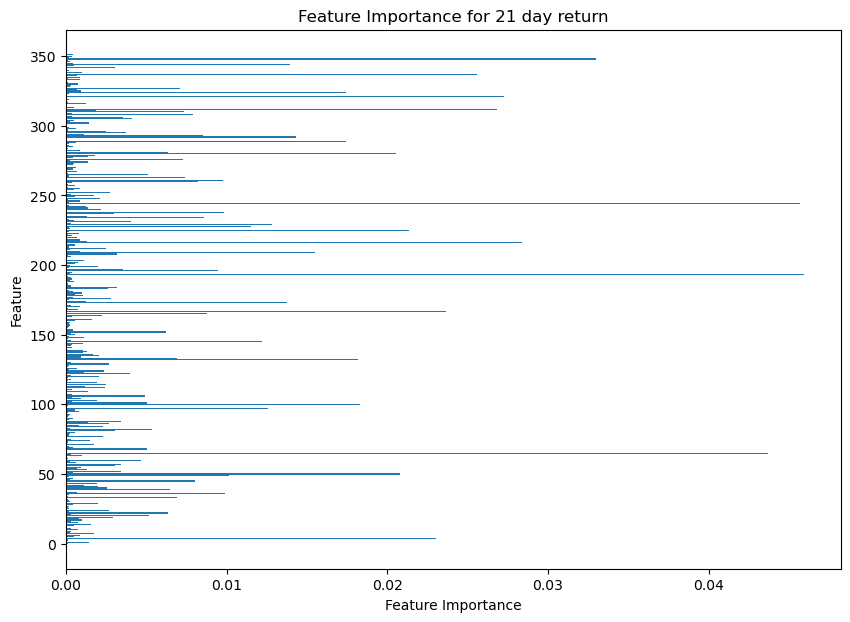

In [15]:
from utils import plot_feature_importance

plot_feature_importance(xgb, X_train, 21)

In [16]:
feature_importance = xgb.feature_importances_
feature_names = np.arange(X_train.shape[1])
sorted_idx = feature_importance.argsort()[::-1]
stocks.drop(columns=["DATE"]).columns[sorted_idx]

Index(['XLP_OPEN', 'XLU_ivol_8d_slope', 'XBI_macd_3d_slope',
       'XOP_ewm_log_ret_1d', 'XLP_macd_21d_slope', 'XLY_log_ret_13d',
       'XLY_ewm_log_ret_3d', 'XLY_rsi_1d_slope', 'XLK_ivol_5d_slope',
       'SPY_SHORT INTEREST RATIO',
       ...
       'XLI_macd_21d_slope', 'SPY_ivol_1d_slope', 'XLV_rsi_21d_slope',
       'XLP_ivol_3d_slope', 'XLE_3M IMPLIED VOL', 'XLY_macd_5d_slope',
       'XLK_log_ret_3d', 'XLE_rsi_13d_slope', 'XLU_ewm_log_ret_3d', 'XLV_LOW'],
      dtype='object', length=352)

In [17]:
stocks.drop(columns=["DATE"]).columns[sorted_idx[:50]]

Index(['XLP_OPEN', 'XLU_ivol_8d_slope', 'XBI_macd_3d_slope',
       'XOP_ewm_log_ret_1d', 'XLP_macd_21d_slope', 'XLY_log_ret_13d',
       'XLY_ewm_log_ret_3d', 'XLY_rsi_1d_slope', 'XLK_ivol_5d_slope',
       'SPY_SHORT INTEREST RATIO', 'XLP_rsi_3d_slope', 'XBI_ivol_1d_slope',
       'XLV_ivol_3d_slope', 'XLE_macd_13d_slope', 'XLI_log_ret_1d', 'XLV_macd',
       'XLY_log_ret_3d', 'XLP_log_ret_21d', 'XLV_macd_21d_slope', 'XOP_LOW',
       'XLK_log_ret_5d', 'XLU_HIGH', 'XLE_log_ret_5d', 'XLI_rsi',
       'XLU_3M IMPLIED VOL', 'XBI_ivol_13d_slope', 'SPY_rsi_5d_slope',
       'XLU_ewm_log_ret_8d', 'XLU_rsi_1d_slope', 'XLP_ewm_log_ret_1d',
       'XLK_ivol_21d_slope', 'XLU_ewm_log_ret_1d', 'XLV_macd_3d_slope',
       'XLU_rsi_13d_slope', 'XBI_ewm_log_ret_21d', 'XLY_SHORT INTEREST RATIO',
       'XLU_rsi_3d_slope', 'XLY_ewm_log_ret_1d', 'XLV_ewm_log_ret_8d',
       'XLY_macd', 'XLI_log_ret_21d', 'SPY_rsi_1d_slope', 'XBI_HIGH',
       'XLV_ivol_5d_slope', 'SPY_log_ret_8d', 'XLK_3M IMPLIED VOL'

Add technical indicators for sentiment